In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np

In [2]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

## Get genotype data

In [6]:
df=pd.read_csv("../../snp-tables/immune-microenvironment-nonhla.tsv",delimiter="\t")

In [10]:
df[df["snps"].str.contains("19:5517")]

,snps,file,category,maf,variant,rsid,tpm beta,tpm SE,tpm P,REF,ALT,firebrowse beta,firebrowse SE,firebrowse P,pancan beta,pancan SE,pancan P,p-value,cis tss,gwas
2,19:55175740:C:T,LILRB4,immunomodulators,0.37430,chr19:g.55175740C>T,rs3745871,0.552741,0.016038,7.971420e-241,C,T,-0.042462,0.017650,1.616310e-02,-0.048756,0.017292,4.823190e-03,7.971420e-241,-1470.0,NaN
3,19:55175983:T:A,LILRB4,immunomodulators,0.05939,chr19:g.55175983T>A,rs7253814,-0.588260,0.035009,3.632880e-62,T,A,0.109191,0.036245,2.599720e-03,0.111202,0.035470,1.725110e-03,3.632880e-62,-1713.0,NaN
5,19:55174498:T:C,LILRB4,immunomodulators,0.19530,chr19:g.55174498T>C,rs28366008,-0.208947,0.020648,6.571470e-24,T,C,0.033695,0.021151,1.111890e-01,0.035240,0.020771,8.982180e-02,6.571470e-24,-228.0,NaN
9,19:55173814:G:C,LILRB4,immunomodulators,0.49030,chr19:g.55173814G>C,rs12609815,0.120665,0.016489,2.799120e-13,G,C,0.003134,0.016854,8.524960e-01,0.003552,0.016554,8.300930e-01,2.799120e-13,456.0,NaN
375,19:55172539:G:A,LILRB4,immunomodulators,0.11120,chr19:g.55172539G>A,rs370156,-0.023649,0.026669,3.752420e-01,G,A,0.146009,0.027148,7.769390e-08,0.143096,0.026698,8.588390e-08,7.769390e-08,1731.0,['Clozapine-induced agranulocytosis']


In [9]:
raw = pd.read_csv('/nrnb/users/mpagadal/tcga-genotypes/germline-immune/immune.snp.raw',sep=' ')

## Get expression data

In [10]:
tpm=pd.read_csv("/cellar/users/mpagadal/Data/projects/germline-immune/discovery/phenotypes/processed_phenos/tpm/tumor/pheno_all_zcancer",delimiter="\t")
firebrowse=pd.read_csv("/cellar/users/mpagadal/Data/projects/germline-immune/discovery/phenotypes/processed_phenos/firebrowse/tumor/pheno_all_zcancer",delimiter="\t")
pancan=pd.read_csv("/cellar/users/mpagadal/Data/projects/germline-immune/discovery/phenotypes/processed_phenos/pancanatlas/tumor/pheno_all_zcancer",delimiter="\t")

## Map to cancer type

In [11]:
canc = pd.read_csv("/nrnb/users/mpagadal/tcga-genotypes/birdseed-processing/gtype.meta", delimiter="\t", header=None)
mp = canc.set_index(2)[0].to_dict()

tpm["cancer"]=tpm["FID"].map(mp)
firebrowse["cancer"]=firebrowse["FID"].map(mp)
pancan["cancer"]=pancan["FID"].map(mp)

In [12]:
geno_immune=pd.merge(raw,tpm,on=["FID","IID"])

### significant snps

In [13]:
snps=pd.read_csv("../../snp-tables/immune-microenvironment-nonhla.tsv",delimiter="\t")

## Plot boxplot of genotype by expression

In [14]:
snp=[x for x in geno_immune.columns if "1:88665329" in x][0]
snp=[x for x in geno_immune.columns if snp in x][0]
gene="CCBL2"

In [15]:
geno_immune_gene=geno_immune[~(geno_immune[gene]==-9)]

In [16]:
geno_immune_gene=geno_immune_gene[geno_immune_gene["cancer"]=="STAD"]

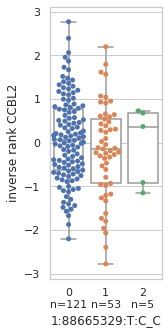

In [17]:
sns.set(style="whitegrid", font_scale = 1)
plt.figure(figsize=(2,5))
ax=sns.boxplot(x=snp,y=gene,data=geno_immune_gene,color="white")
ax=sns.swarmplot(x=snp,y=gene,data=geno_immune_gene)

labels = [item.get_text() for item in ax.get_xticklabels()]
labels=[x+"\nn="+str(len(geno_immune_gene[geno_immune_gene[snp]==int(x)])) for x in labels]

ax.set_xticklabels(labels)
plt.ylabel("inverse rank "+gene)


plt.savefig("../plots/"+snp+"."+gene+".pdf")

## Get FPKM expression

In [18]:
fpkm=pd.read_csv("/cellar/users/mpagadal/Data/resources/tcga/fpkm-compile/tcga-hugo-fpkm-compiled",delimiter="\t")

In [20]:
mp_fpkm=pd.read_csv("/cellar/users/mpagadal/Data/resources/from-labmembers/andrea/uuid_barcode_map.txt",delimiter="\t")
mp_fpkm["file_name"]=mp_fpkm["file_name"].str.split(".gz").str[0]
mp_fpkm=dict(zip(mp_fpkm["file_name"],mp_fpkm["sample_barcode"]))

In [21]:
cols=[]

for x in fpkm.columns:
    try:
        cols.append(mp_fpkm[x])
    except:
        cols.append(x)

In [22]:
fpkm.columns=cols

In [23]:
#keep only primary tumor samples
keep_cols=[x for x in fpkm.columns if x[13:15]=="01"]

In [24]:
fpkm=fpkm.set_index("HUGO")
fpkm_tumor=fpkm[keep_cols]

In [25]:
fpkm_tumor=fpkm_tumor.T
fpkm_tumor.index=fpkm_tumor.index.str[0:12]

In [26]:
fpkm_tumor=fpkm_tumor.reset_index()

In [27]:
fpkm_tumor=fpkm_tumor.rename(columns={"index":"FID"})

In [28]:
#take mean of duplicate samples
fpkm_tumor=fpkm_tumor.groupby("FID").mean()

In [29]:
#normalized expression
fpkm_tumor+=1
fpkm_tumor=np.log2(fpkm_tumor)

In [30]:
geno_immune=pd.merge(raw,fpkm_tumor,on="FID",how="left")

In [31]:
snp=[x for x in geno_immune.columns if "6:58602122:A:G" in x][0]
gene="LINC00680"

Text(0, 0.5, 'log2 FPKM LINC00680')

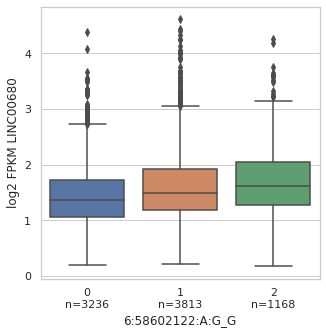

In [32]:
sns.set(style="whitegrid", font_scale = 1)
plt.figure(figsize=(5,5))
ax=sns.boxplot(x=snp,y=gene,data=geno_immune)

labels = [item.get_text() for item in ax.get_xticklabels()]
labels=[x+"\nn="+str(len(geno_immune[geno_immune[snp]==int(x)])) for x in labels]

ax.set_xticklabels(labels)
plt.ylabel("log2 FPKM "+gene)


## Get gtex trans dataframe

In [33]:
snps=pd.read_csv("../../snp-tables/immune-microenvironment-nonhla.tsv",delimiter="\t")

In [34]:
snps[snps["snps"]=="6:58602122:A:G"]

,snps,file,category,maf,variant,rsid,tpm beta,tpm SE,tpm P,REF,ALT,firebrowse beta,firebrowse SE,firebrowse P,pancan beta,pancan SE,pancan P,p-value,cis tss,gwas
272,6:58602122:A:G,CD14,immunomodulators,0.3742,chr6:g.58602122A>G,rs2693076,-0.093316,0.017182,5.792990e-08,A,G,-0.091864,0.017469,1.495620e-07,-0.096153,0.017098,1.940020e-08,1.940020e-08,NaN,NaN
430,6:58602122:A:G,LILRB2,antigen present,0.3742,chr6:g.58602122A>G,rs2693076,-0.075616,0.017100,9.929310e-06,A,G,-0.086076,0.017492,8.815400e-07,-0.093224,0.017121,5.355250e-08,5.355250e-08,NaN,NaN
440,6:58602122:A:G,PLEK,immunomodulators,0.3742,chr6:g.58602122A>G,rs2693076,-0.080416,0.017210,3.029850e-06,A,G,-0.082619,0.017492,2.365900e-06,-0.093917,0.017121,4.264090e-08,4.264090e-08,NaN,NaN
449,6:58602122:A:G,MYO1F,immunomodulators,0.3742,chr6:g.58602122A>G,rs2693076,-0.055857,0.017233,1.195190e-03,A,G,-0.090779,0.017493,2.169950e-07,-0.099323,0.017122,6.876240e-09,6.876240e-09,NaN,NaN
456,6:58602122:A:G,LAIR1,immunomodulators,0.3742,chr6:g.58602122A>G,rs2693076,-0.065084,0.017203,1.560190e-04,A,G,-0.091273,0.017470,1.796370e-07,-0.098363,0.017102,9.204820e-09,9.204820e-09,NaN,NaN


In [38]:
genes=snps[snps["snps"]=="6:58602122:A:G"]["file"].tolist()

In [39]:
snp=["6:58602122:A:G_G"]

In [40]:
cols=[x for x in set(snp+genes+["LINC00680"])]

In [41]:
linc_geno_immune=geno_immune[cols]

In [42]:
mean=linc_geno_immune.groupby(snp).mean()

In [43]:
std=linc_geno_immune.groupby(snp).std()

In [44]:
std=std/3

In [45]:
mean

,LAIR1,CD14,MYO1F,LILRB2,LINC00680,PLEK
6:58602122:A:G_G,,,,,,
0,1.785180,5.089867,1.722445,1.308952,1.436832,2.601566
1,1.703170,4.962315,1.654841,1.245929,1.589918,2.511153
2,1.622372,4.842778,1.581670,1.183360,1.689108,2.383163


LAIR1
CD14
MYO1F
LILRB2
PLEK


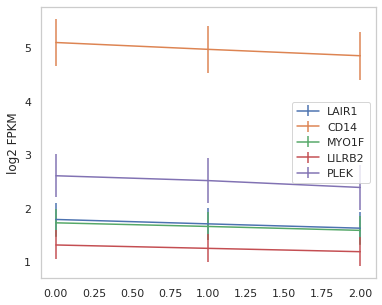

In [46]:
plt.figure(figsize=(6,5))
for i in mean.columns:
    if i!= "LINC00680":
        print(i)
        plt.errorbar([0,1,2], mean[i].tolist(), yerr=std[i].tolist(),label=i) 
plt.legend()
plt.grid(b=None)
plt.ylabel("log2 FPKM")
plt.savefig("../plots/LINC00680.mac.pdf", bbox_inches='tight')

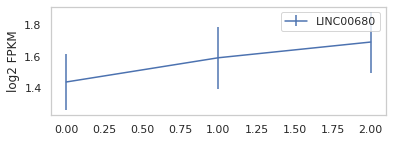

In [47]:
plt.figure(figsize=(6,2))
plt.errorbar([0,1,2], mean["LINC00680"].tolist(), yerr=std["LINC00680"].tolist(),label="LINC00680") 
plt.legend()
plt.ylabel("log2 FPKM")
plt.grid(b=None)
plt.savefig("../plots/LINC00680.pdf", bbox_inches='tight')